<a href="https://colab.research.google.com/github/tsaialice9/HW1_VAE_MNIST/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!mkdir -p mnist_data
!wget -O mnist_data/train-images-idx3-ubyte.gz https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz
!wget -O mnist_data/train-labels-idx1-ubyte.gz https://raw.githubusercontent.com/fgnt/mnist/master/train-labels-idx1-ubyte.gz
!wget -O mnist_data/t10k-images-idx3-ubyte.gz https://raw.githubusercontent.com/fgnt/mnist/master/t10k-images-idx3-ubyte.gz
!wget -O mnist_data/t10k-labels-idx1-ubyte.gz https://raw.githubusercontent.com/fgnt/mnist/master/t10k-labels-idx1-ubyte.gz

import gzip
import numpy as np

def load_mnist_images(filename, num_samples):
    with gzip.open(filename, 'rb') as f:
        header = np.frombuffer(f.read(16), dtype='>i4')
        magic, n, rows, cols = header
        data = np.frombuffer(f.read(num_samples * rows * cols), dtype=np.uint8)
        return data.reshape(num_samples, rows, cols) / 255.0

def load_mnist_labels(filename, num_samples):
    with gzip.open(filename, 'rb') as f:
        header = np.frombuffer(f.read(8), dtype='>i4')
        magic, n = header
        labels = np.frombuffer(f.read(num_samples), dtype=np.uint8)
        return labels

train_x = load_mnist_images("mnist_data/train-images-idx3-ubyte.gz", 60000)
train_y = load_mnist_labels("mnist_data/train-labels-idx1-ubyte.gz", 60000)
test_x  = load_mnist_images("mnist_data/t10k-images-idx3-ubyte.gz", 10000)
test_y  = load_mnist_labels("mnist_data/t10k-labels-idx1-ubyte.gz", 10000)

print("Train:", train_x.shape, train_y.shape)
print("Test :", test_x.shape, test_y.shape)

--2025-09-18 13:59:57--  https://raw.githubusercontent.com/fgnt/mnist/master/train-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/octet-stream]
Saving to: ‘mnist_data/train-images-idx3-ubyte.gz’

mnist_data/train-im 100%[===================>]   9.45M  --.-KB/s    in 0.1s    

2025-09-18 13:59:57 (90.5 MB/s) - ‘mnist_data/train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-09-18 13:59:58--  https://raw.githubusercontent.com/fgnt/mnist/master/train-labels-idx1-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

Epoch 1, Average loss: 163.2876
Epoch 2, Average loss: 121.2193
Epoch 3, Average loss: 114.3585
Epoch 4, Average loss: 111.3662
Epoch 5, Average loss: 109.6062


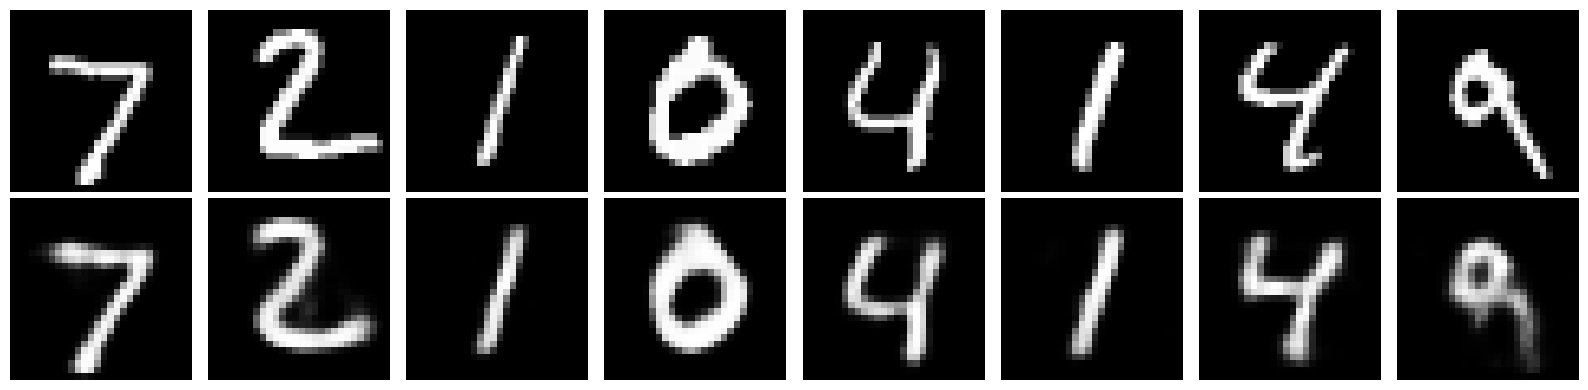

In [10]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(train_x, dtype=torch.float32),
                              torch.tensor(train_y, dtype=torch.long))
test_dataset  = TensorDataset(torch.tensor(test_x, dtype=torch.float32),
                              torch.tensor(test_y, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)


import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)  # 固定隨機種子
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}, Average loss: {avg_loss:.4f}")


import matplotlib.pyplot as plt

def test_and_show(test_loader, num_samples=8):
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        plt.figure(figsize=(num_samples*2, 4))
        for i in range(num_samples):
            # 原圖
            plt.subplot(2, num_samples, i+1)
            plt.imshow(data[i].cpu().view(28,28), cmap='gray')
            plt.axis('off')
            if i==0: plt.ylabel("Input", fontsize=12)

            # 重建
            plt.subplot(2, num_samples, i+1+num_samples)
            plt.imshow(recon[i].cpu().view(28,28), cmap='gray')
            plt.axis('off')
            if i==0: plt.ylabel("Reconstruction", fontsize=12)
        plt.tight_layout()
        plt.show()


for epoch in range(1, epochs+1):
    train(epoch)

test_and_show(test_loader, num_samples=8)